In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

General outlook: 

* Current season and historical scoring -> swarm plot of points at each game

    * Distribution of points from locations compared with those other top scorers (2pt/3pt/FT)
    
    * Compare how many field goals which he made were assisted/unassisted with this year/historic players
    
    * Compare free throw shooting with other players.
    
    * Step backs comparison (like with Doncic)
    
    * Step backs shot chart
    
    * Shotchart for this year
    
        
* Evolution of Harden

    * Shotchart through time would be nice to see
    
    * How his usage rose through time
    
    * Change in style from OKC to HOU
    
    
* Comparsion with Phoenix' system with D'Antoni

    * Compare Harden with Steve Nash
    
    * Shot charts comparison

## Setup

In [6]:
from nba_api.stats.static.players import find_players_by_full_name

In [7]:
harden_data = find_players_by_full_name("James Harden")

In [8]:
harden_id = harden_data[0]['id']

## Analyzing shooting splits

In [14]:
import time

In [5]:
from nba_api.stats.endpoints.playerdashboardbyshootingsplits import PlayerDashboardByShootingSplits

In [11]:
int_seasons = list(range(2009, 2019))

In [32]:
harden_shot_types_df = None
harden_overall_df = None
seasons = list()
for i in range(len(int_seasons)):
    season_str = str(int_seasons[i]) + "-" + str(int_seasons[i]+1)[-2:]
    data_frames = PlayerDashboardByShootingSplits(
            player_id=harden_id,
            season=season_str).get_data_frames()
    shot_type_detail = data_frames[-2]
    shot_type_detail.loc[:, 'SEASON'] = season_str
    overall = data_frames[0]
    overall.loc[:, 'SEASON'] = season_str
    time.sleep(1)
    if harden_shot_types_df is None:
        harden_shot_types_df = shot_type_detail
        harden_overall_df = overall
    else:
        harden_shot_types_df = harden_shot_types_df.append(shot_type_detail, ignore_index=True)
        harden_overall_df = harden_overall_df.append(overall, ignore_index=True)

In [44]:
step_backs = harden_shot_types_df.loc[harden_shot_types_df.GROUP_VALUE == 'Step Back Jump shot']

In [40]:
plt.style.use('seaborn')

In [48]:
step_backs.FGA.tolist()

[2, 15, 17, 70, 147, 191, 199, 155, 267, 375]

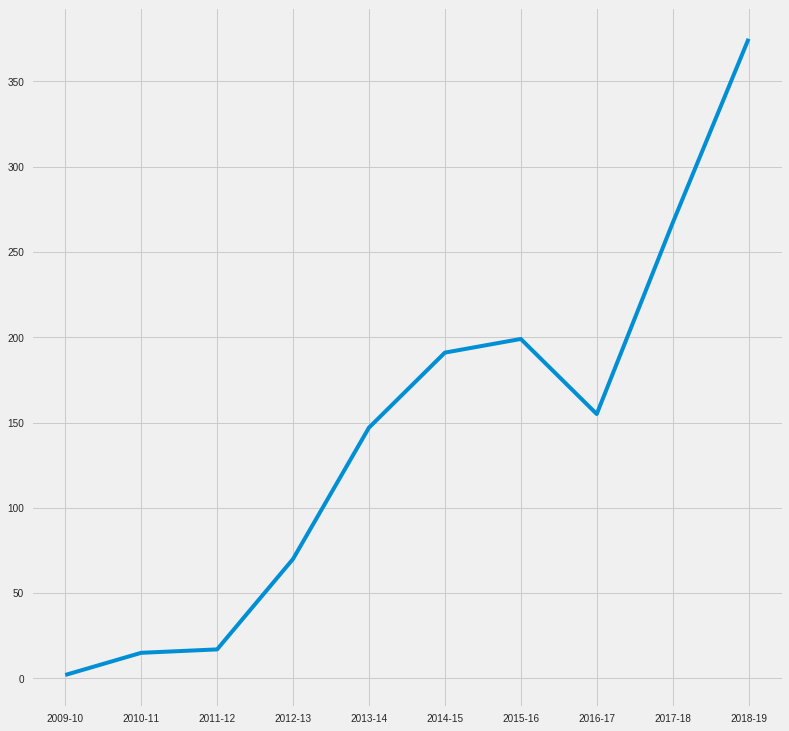

In [64]:
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize=(12, 12))

ax.plot('SEASON', 'FGA', data=step_backs)


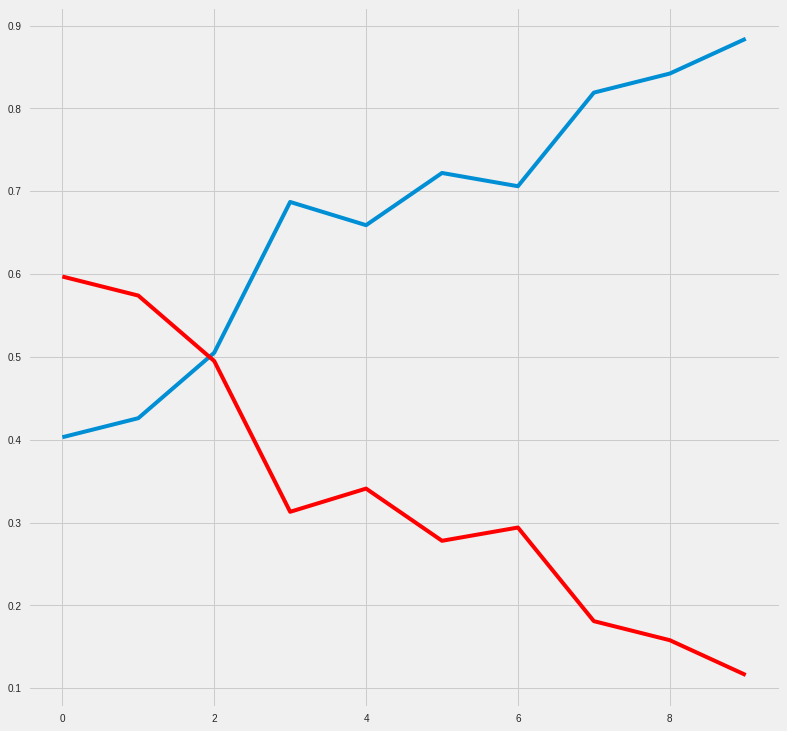

In [60]:
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize=(12, 12))

ax.plot(harden_overall_df.PCT_UAST_FGM)
ax.plot(harden_overall_df.PCT_AST_FGM, color='r')

## Comparison with historic top scorers

In [5]:
import requests
from bs4 import BeautifulSoup

In [7]:
def get_urls_for_top_scorers(url):
    res = requests.get(top_scorers_url)
    soup = BeautifulSoup(res.text)
    item = soup.find(attrs={'class': 'stats_table'})
    rows = item.findAll("tr")
    urls = list()
    for row in rows:
        header_cells = row.findAll("th")
        for header_cell in header_cells:
            if 'data-stat' in header_cell.attrs and header_cell['data-stat'] == 'ranker' and 'csk' in header_cell.attrs:
                rank = int(header_cell.getText())
        td_cells = row.findAll("td")
        if not td_cells:
            continue
        for cell in td_cells:
            if 'data-stat' in cell.attrs and cell['data-stat'] == 'season':
                season = int(cell.getText().split("-")[0])+1
            if 'data-stat' in cell.attrs and cell['data-stat'] == 'player':
                url = cell.findAll("a")[0]['href']
        game_log_url = bbref_base + url.split(".")[0] + "/gamelog/" + str(season)
        urls.append(game_log_url)
    return urls

In [25]:
import re

def get_player_name_points(url, limit):
    response = requests.get(url)
    soup = BeautifulSoup(response.text)
    title = soup.find('h1').getText()
    splitted = re.split('\d{4}-\d{2}', title)
    name = splitted[0].strip()
    dash_splitted = title.split('-')
    season = dash_splitted[0].split(" ")[-1] + "-" + dash_splitted[1].split(" ")[0]
    player_names = list()
    seasons = list() # this will be filled with same values
    points = list()
    
    rows = soup.findAll('tr')
    for row in rows:
        cells = row.findAll('td')
        for cell in cells:
            if 'data-stat' in cell.attrs and cell['data-stat'] == 'reason':
                continue
            if 'data-stat' in cell.attrs and cell['data-stat'] == 'game_season':
                if cell.getText() == "":
                    continue
                if int(cell.getText()) > limit:
                    break
            if 'data-stat' in cell.attrs and cell['data-stat'] == 'pts':
                points.append(int(cell.getText()))
                player_names.append(name)
                seasons.append(season)
    
    return player_names, seasons, points

In [12]:
url = 'https://www.basketball-reference.com/players/h/hardeja01/gamelog/2019'
names, seasons, points = get_player_name_points(url)

In [20]:
top_scorers_urls = [
    'https://www.basketball-reference.com/players/j/jordami01/gamelog/1987',
    'https://www.basketball-reference.com/players/h/hardeja01/gamelog/2019',
    'https://www.basketball-reference.com/players/b/bryanko01/gamelog/2006',
    'https://www.basketball-reference.com/players/i/iversal01/gamelog/2006',
    'https://www.basketball-reference.com/players/m/mcgratr01/gamelog/2003',
    'https://www.basketball-reference.com/players/d/duranke01/gamelog/2014',
    'https://www.basketball-reference.com/players/w/westbru01/gamelog/2017',
    'https://www.basketball-reference.com/players/j/jamesle01/gamelog/2006',
]

In [29]:
import time
full_names, full_seasons, full_points = [], [], []
harden_total_games = 51
for url in top_scorers_urls:
    print(f"Current url: {url}")
    names, seasons, points = get_player_name_points(url, limit=harden_total_games)
    time.sleep(0.5)
    full_names.extend(names)
    full_seasons.extend(seasons)
    full_points.extend(points)

data_frame = pd.DataFrame(data={
    'PLAYER': full_names,
    'SEASON': full_seasons,
    'POINTS': full_points
})

Current url: https://www.basketball-reference.com/players/j/jordami01/gamelog/1987
Current url: https://www.basketball-reference.com/players/h/hardeja01/gamelog/2019
Current url: https://www.basketball-reference.com/players/b/bryanko01/gamelog/2006
Current url: https://www.basketball-reference.com/players/i/iversal01/gamelog/2006
Current url: https://www.basketball-reference.com/players/m/mcgratr01/gamelog/2003
Current url: https://www.basketball-reference.com/players/d/duranke01/gamelog/2014
Current url: https://www.basketball-reference.com/players/w/westbru01/gamelog/2017
Current url: https://www.basketball-reference.com/players/j/jamesle01/gamelog/2006


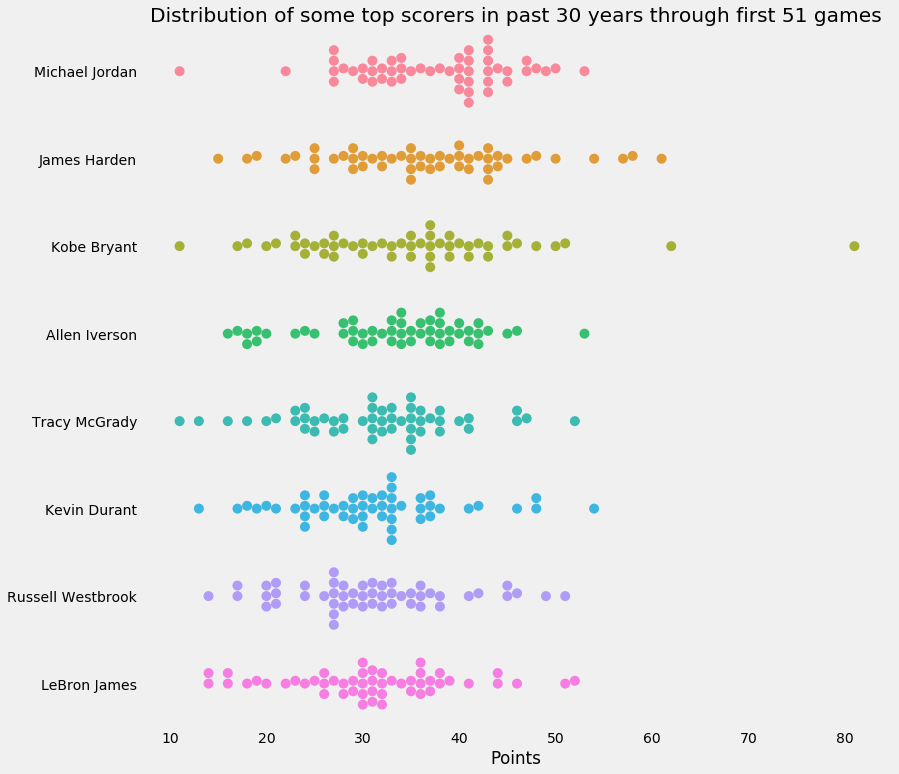

In [59]:
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize=(12, 12))
sns.swarmplot(y='PLAYER', x='POINTS', data=data_frame, ax=ax, size=10)
ax.grid(False)
ax.set_xlabel('Points')
ax.set_ylabel('')
_ = ax.set_title('Distribution of some top scorers in past 30 years through first 51 games')

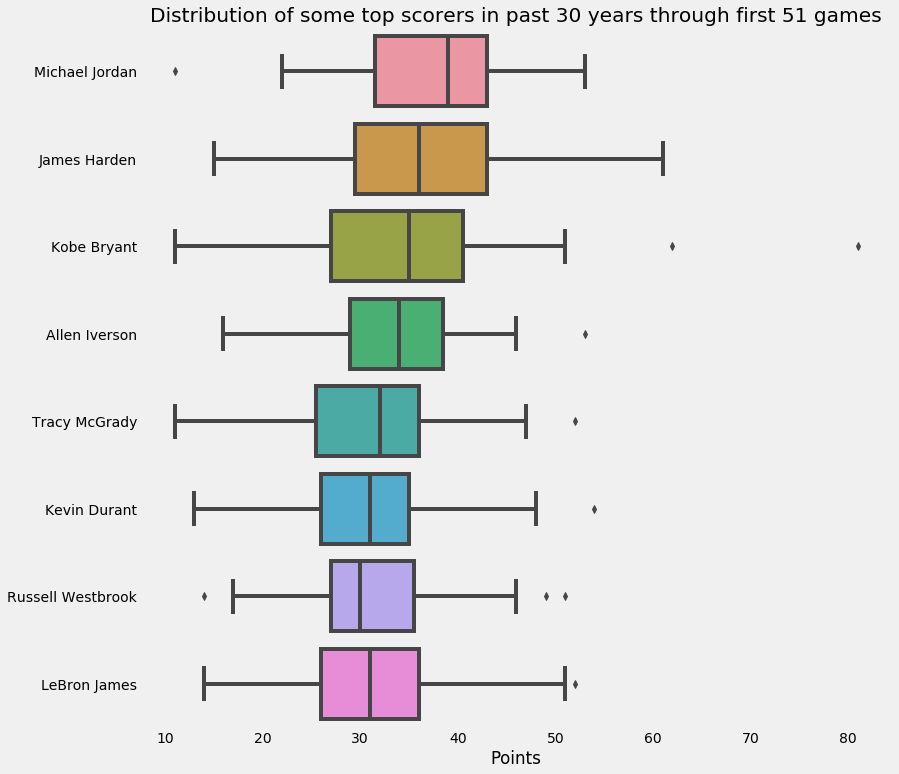

In [60]:
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize=(12, 12))
sns.boxplot(y='PLAYER', x='POINTS', data=data_frame, ax=ax)
ax.grid(False)
ax.set_xlabel('Points')
ax.set_ylabel('')
_ = ax.set_title('Distribution of some top scorers in past 30 years through first 51 games')

## Unassisted vs assisted Field goals

In [5]:
from nba_api.stats.endpoints.leaguedashplayerstats import LeagueDashPlayerStats

In [6]:
base_stats = LeagueDashPlayerStats(measure_type_detailed_defense='Base')

In [8]:
base_df = base_stats.get_data_frames()[0]

In [10]:
scoring_stats = LeagueDashPlayerStats(measure_type_detailed_defense='Scoring')
scoring_df = scoring_stats.get_data_frames()[0]

In [20]:
base_df = base_df.sort_values(by='PTS', ascending=False)

In [30]:
merged_df = pd.merge(base_df, scoring_df, how='inner', on='PLAYER_ID')

interesting keys: 'PTS', 'FGM', 'FGA', '3FGM', '3FGA', 'PCT_UAST_FGM', 'PCT_AST_FGM'

In [75]:
def calculate_total_uast_ast(data_frame):
    data_frame.loc[:, 'UAST_FGM'] = (data_frame.FGM * data_frame.PCT_UAST_FGM).astype(int, errors='ignore')
    data_frame.loc[:, 'AST_FGM'] = (data_frame.FGM * data_frame.PCT_AST_FGM).astype(int, errors='ignore')
    
    data_frame.loc[:, 'UAST_FG3M'] = (data_frame.FG3M * data_frame.PCT_UAST_3PM).astype(int, errors='ignore')
    data_frame.loc[:, 'AST_FG3M'] = (data_frame.FG3M * data_frame.PCT_AST_3PM).astype(int, errors='ignore')
    
    
    return data_frame

In [76]:
total_merged_df = calculate_total_uast_ast(merged_df)

In [81]:
top_150_scorers_df = total_merged_df.iloc[:150]

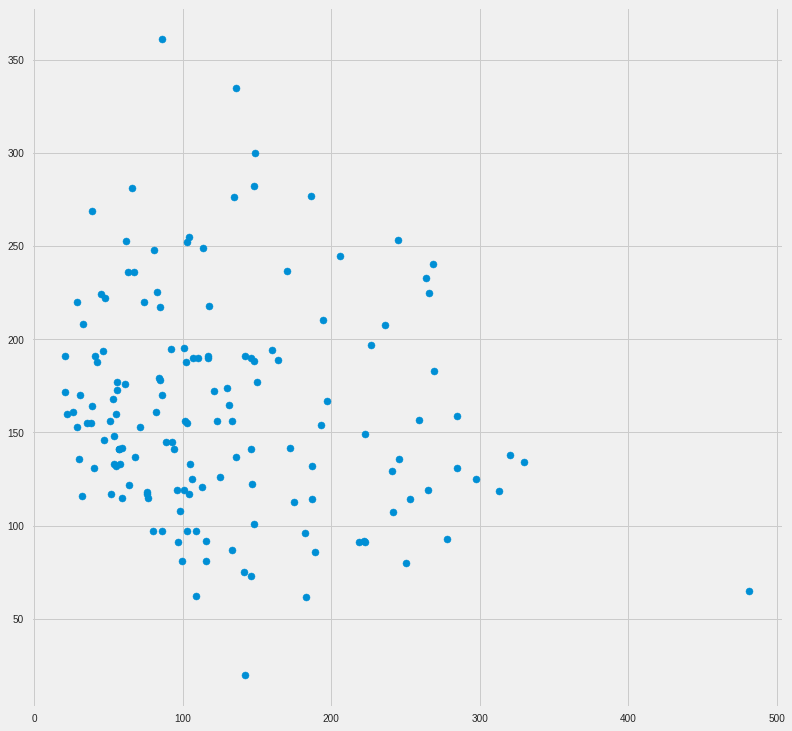

In [82]:
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize=(12, 12))

ax.scatter(x=top_150_scorers_df.UAST_FGM, y=top_150_scorers_df.AST_FGM)


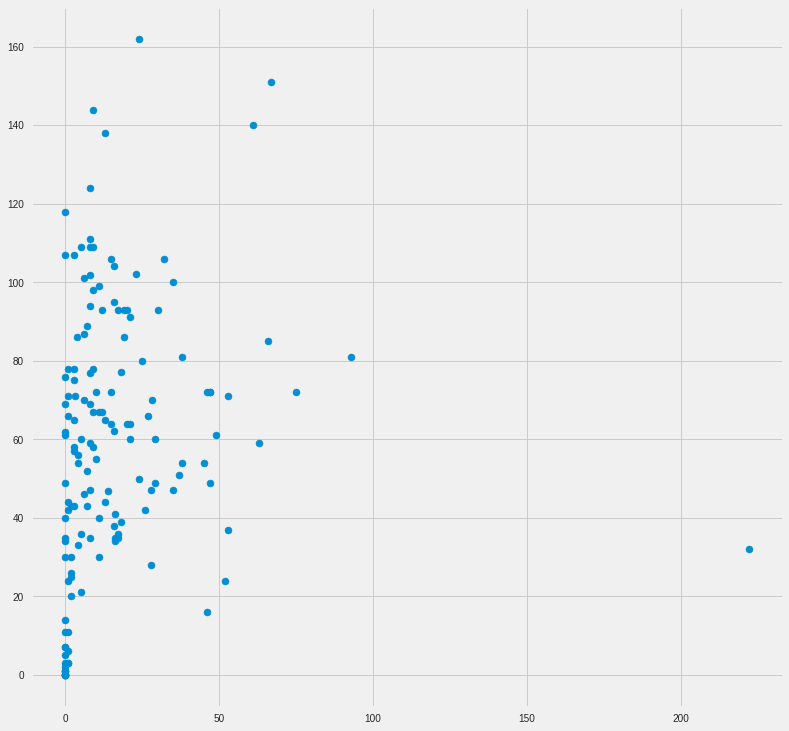

In [83]:
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize=(12, 12))

ax.scatter(x=top_150_scorers_df.UAST_FG3M, y=top_150_scorers_df.AST_FG3M)

Maybe add in comparison with top scorers in last 10-15 years (15 years, top 10 players is ok)

## Usage and efficiency

While Harden is having tremendously high scoring season, how efficient is he? And how big is his usage? I'll take on that in next couple of cells.

In [9]:
from nba_api.stats.endpoints.leaguedashplayerstats import LeagueDashPlayerStats

In [119]:
basic_stats = LeagueDashPlayerStats()
basic_df = basic_stats.get_data_frames()[0]

In [10]:
advanced_stats = LeagueDashPlayerStats(measure_type_detailed_defense="Advanced")

In [11]:
advanced_df = advanced_stats.get_data_frames()[0]

In [12]:
advanced_df_filtered = advanced_df.loc[advanced_df.GP > 20]

In [13]:
advanced_df_filtered = advanced_df_filtered.sort_values(by="USG_PCT", ascending=False)

In [14]:
from numpy.polynomial.polynomial import polyfit

In [120]:
merged_df = pd.merge(basic_df, advanced_df, on='PLAYER_ID')

In [137]:
filtered_data = merged_df.sort_values(by='PTS', ascending=False)
filtered_data = filtered_data.iloc[:200]

In [133]:
filter_out_harden = filtered_data.loc[filtered_data.PLAYER_NAME_x == 'James Harden']

In [138]:
from adjustText import adjust_text

Text(0.5, 1.0, 'Efficiency based on usage for 2018-19 season')

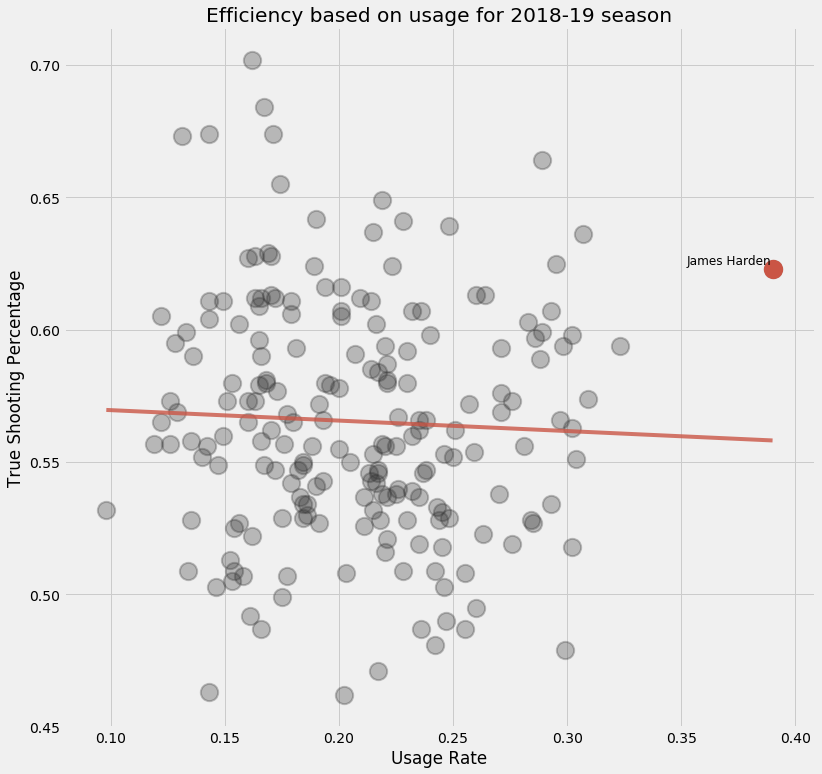

In [141]:

plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize=(12, 12))

b, m = polyfit(filtered_data.USG_PCT, filtered_data.TS_PCT, deg=1)

x_usg = np.linspace(filtered_data.USG_PCT.min(), filtered_data.USG_PCT.max(), 200)

ax.plot(x_usg, b + m * x_usg, color="#CA5545", alpha=0.8)
ax.scatter(x=filtered_data.USG_PCT, y=filtered_data.TS_PCT, s=300, alpha=0.3, linewidths=2.0, color="#343434")

ax.scatter(x=filter_out_harden.USG_PCT, y=filter_out_harden.TS_PCT, s=300, linewidths=2.0, color="#CA5545")
text = [ax.text(x=filter_out_harden.USG_PCT.iloc[0], y=filter_out_harden.TS_PCT.iloc[0], s="James Harden", fontsize=12)]
adjust_text(texts=text)

ax.set_xlabel('Usage Rate')
ax.set_ylabel('True Shooting Percentage')
ax.set_title('Efficiency based on usage for 2018-19 season')

### Top scorers in advanced era

Here I took a look at top 100 scorers in three point era, and how they efficient they were with more workload on their back.

In [146]:
data_frame = pd.read_csv('top_100_3pt_era.csv')

In [147]:
harden_only = data_frame.loc[(data_frame.Player == 'James Harden') & (data_frame.Season == '2018-19')]

In [148]:
from numpy.polynomial.polynomial import polyfit

In [149]:
usages = np.array(data_frame.USG_PCT)
square_usages = usages ** 2

b, m1 = polyfit(data_frame.USG_PCT, data_frame.TS_PCT, deg=1)

In [150]:
x_usages = np.linspace(int(data_frame.USG_PCT.min()), int(data_frame.USG_PCT.max())+1, 100)

Text(0.5, 1.0, 'Efficiency of top 100 scorers since 1979-80')

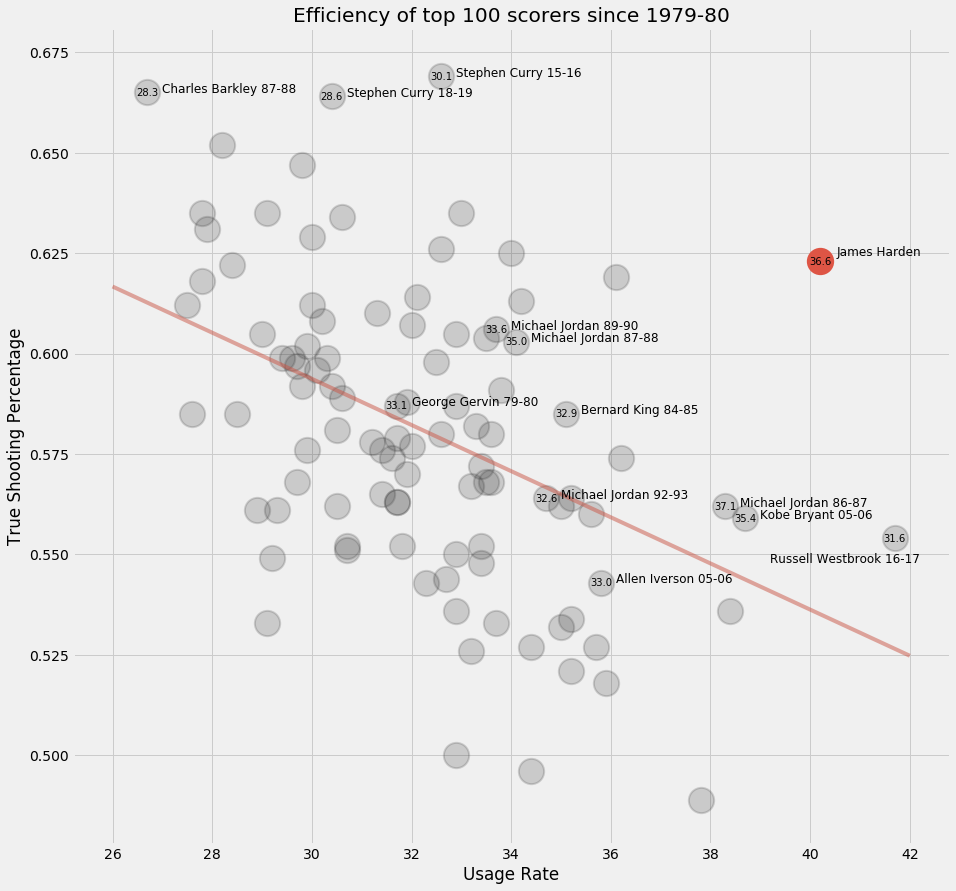

In [190]:
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize=(14, 14))


ax.plot(x_usages, b + m1 * x_usages, color="#CA5545", alpha=0.5)

texts=[]
for i in range(len(data_frame)):
    item = data_frame.iloc[i]
    if item.Player == 'James Harden' and item.Season == '2018-19':
        ax.scatter(x=item.USG_PCT, y=item.TS_PCT, s=640, linewidths=2.0, color="#DE5545")
        text = [ax.text(x=item.USG_PCT, y=item.TS_PCT, s="James Harden", fontsize=12)]
        ax.text(x=item.USG_PCT, y=item.TS_PCT, s=item.PTS, fontsize=10, ha='center', va='center')
        continue
    ax.scatter(x=item.USG_PCT, y=item.TS_PCT, s=640, alpha=0.2, linewidths=2.0, color="#343434")
    if item.Rk < 10 or item.TS_PCT > 0.66 or item.USG_PCT > 40:
        season = item.Season[-5:]
        name = item.Player
        points = item.PTS
        if name == "Russell Westbrook":
            texts.append(ax.text(x=item.USG_PCT + - 2.5, y=item.TS_PCT -0.006, s=name + " " + season, fontsize=12))
        else:
            texts.append(ax.text(x=item.USG_PCT + 0.3, y=item.TS_PCT, s=name + " " + season, fontsize=12))
        ax.text(x=item.USG_PCT, y=item.TS_PCT, s=points, fontsize=10, ha='center', va='center')
# ax.scatter(x=data_frame.USG_PCT, y=data_frame.TS_PCT, s=500, alpha=0.2, linewidths=2.0, color="#343434")

# ax.scatter(x=harden_only.USG_PCT, y=harden_only.TS_PCT, s=500, linewidths=2.0, color="#CA5545")
# text = [ax.text(x=harden_only.USG_PCT.iloc[0], y=harden_only.TS_PCT.iloc[0], s="James Harden", fontsize=12)]
adjust_text(texts=text, expand_points=(1.4, 1.4), autoalign='xy')
# ax.text(x=harden_only.USG_PCT.iloc[0], y=harden_only.TS_PCT.iloc[0], s=harden_only.PTS.iloc[0], fontsize=10, ha='center', va='center')

ax.set_xlabel('Usage Rate')
ax.set_ylabel('True Shooting Percentage')
ax.set_title('Efficiency of top 100 scorers since 1979-80')